# Discrete Task:
- Load data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from discrete_helper_functions import *
from comparison_helper_functions import *

# Load the datasets from the saved numpy arrays in the Familiarization task
X = np.load('./train_data.npy')
y = np.load('./train_labels.npy')
X_test = np.load('./test_data.npy')

train_data = pd.read_pickle('./train_data_df.pkl')

# Seperate the two training datasets
# X1, y1 = training data and labels 1 (normal behaviour)
# X2, y2 = training data and labels 2 (attacks present)
num = 8761
X1 = X[:num]
X2 = X[num:]
y1 = y[:num]
y2 = y[num:]

ss = StandardScaler()
X1_scaled = ss.fit_transform(X1)
X2_scaled = ss.fit_transform(X2)

# Check that everything is there
print("Training dataset shape: ", X.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of attacks: ", np.sum(y==1))

Training dataset shape:  (12938, 40)
Test dataset shape:  (2089, 40)
Number of attacks:  219


## Discrete Methods

#### Sybmolic Aggregate Approximation

[[[0]
  [0]
  [1]
  [2]
  [2]
  [2]
  [2]
  [1]]]


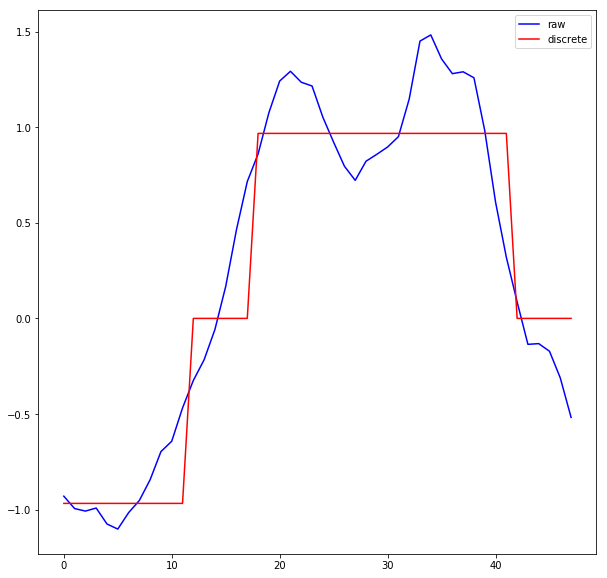

In [131]:
from tslearn.piecewise import SymbolicAggregateApproximation

offset = 10
window_size = 48
raw_data = X1_scaled[offset: offset+window_size, 0]

n_sax_symbols = 3
sax = SymbolicAggregateApproximation(n_segments=8, alphabet_size_avg=n_sax_symbols)
sax_dataset = sax.fit_transform(raw_data)
sax_dataset_inv = sax.inverse_transform(sax_dataset)

print(sax_dataset)
# print(sax_dataset_inv)
plt.figure(figsize = (10,10))
plt.plot(raw_data, color = 'b', label = 'raw')
plt.plot(sax_dataset_inv[0], color = 'r', label = 'discrete')
plt.legend()

In [135]:
# Discretise train and test signal
train_sax=sax_via_window(X1[:, 0], 48, 8, alphabet_size=3,
               nr_strategy='none', z_threshold=0.01)
test_sax = sax_via_window(X2[:,0], 48, 8, alphabet_size=3,
                         nr_strategy='none')

In [125]:
signal = X1_scaled[:, 0]
window_size = 48
paa_segments = 8
alphabet_size = 3

def discretize(raw_signal, window_size, paa_segments, alphabet_size):
    sax = SymbolicAggregateApproximation(n_segments=paa_segments, alphabet_size_avg=alphabet_size)
    discrete_signal = []
    num = len(signal)//window_size
    
    for i in range(num):
        raw = raw_signal[i*window_size : (i+1)*window_size]
        disc = sax.inverse_transform(sax.fit_transform(raw_data))
        discrete_signal.append(np.squeeze(disc))
    discrete_signal = [x for sublist in discrete_signal for x in sublist]
    
    return discrete_signal

discrete_signal = discretize(signal, window_size, paa_segments, alphabet_size)

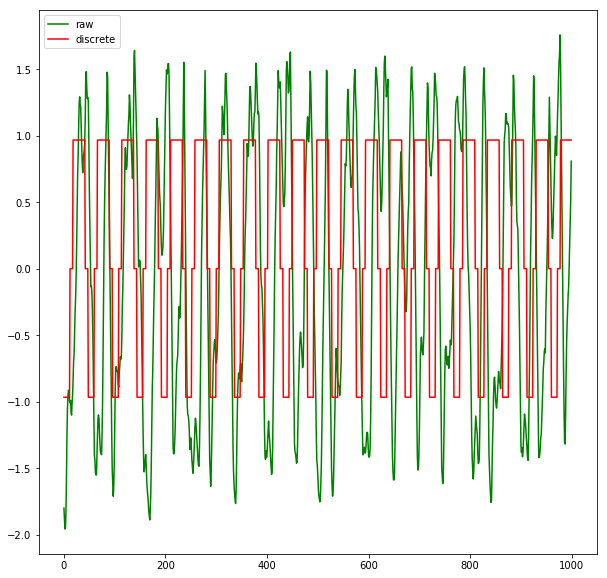

In [126]:
plt.figure(figsize=(10,10))
plt.plot(signal[:1000], color='g', label = 'raw')
plt.plot(discrete_signal[:1000], color='r', label = 'discrete')
plt.legend()

In [133]:
def discretizeV2(raw_signal, window_size, paa_segments):
    discrete_signal = []
    num = window_size//paa_segments

    for i in range(0, len(signal), window_size):
        for ngram in list(train_sax.keys()):
            if i in train_sax[ngram]:
                for n in range(8):
                    discrete_signal.append(np.tile(ngram[n], num))

    discrete_signal = [x for sublist in discrete_signal for x in sublist]
    return discrete_signal

discrete_signal = discretizeV2(signal, window_size, paa_segments)

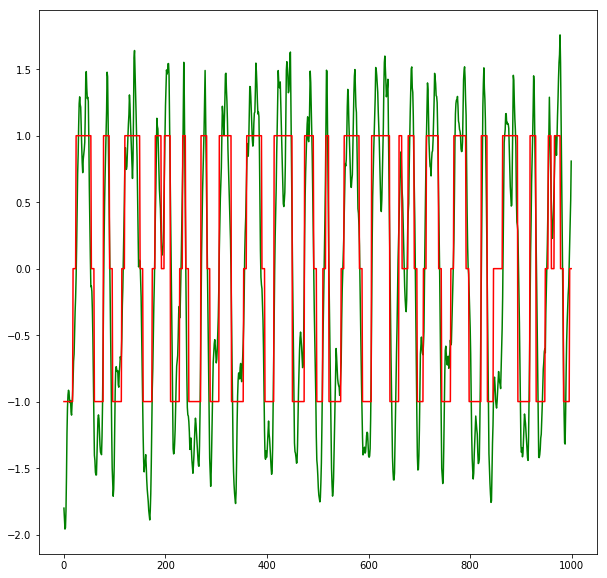

In [134]:
enum = {'a':-1, 'b': 0, 'c':1}
disc_enum = [enum[x] for x in disc]

plt.figure(figsize=(10,10))
plt.plot(signal[:1000], color='g', label='raw')
plt.plot(disc_enum[:1000], color='r', label='discrete')

In [4]:
# Extract ngram probabilities and training profile based on most frequent ngrams
train_probs = extract_ngram_probs(train_sax)

labels = np.array(y2, copy=True)
labels[labels==-999] = 0

train_prof = extract_train_prof(train_probs, thres=1)

# raise an alarm for encountered ngrams in the test signal, not present in the 
# training profile
alarm_regions = extract_alarm_regions(test_sax, train_prof)

In [5]:
# Compute score S
gamma=0.5

predicted_labels = np.zeros_like(labels)
predicted_labels[alarm_regions] = 1

sttd = compute_sttd(labels, predicted_labels)
cm = estimate_confusion_matrix(labels, predicted_labels)
scm = compute_scm(cm)
s = compute_s(labels, predicted_labels,gamma)

print(cm.shape)
print(sttd, scm)
print(s)

(2, 2)
0.41799333580155495 0.5877068811562502
0.5028501084789025


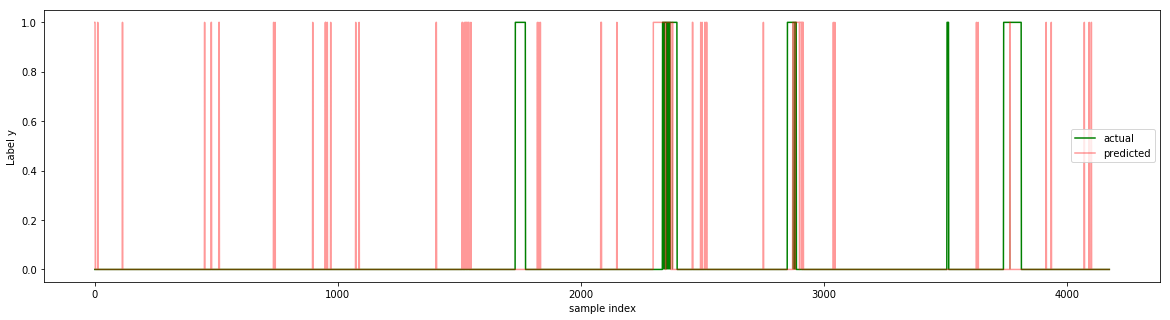

In [6]:
plot(labels, predicted_labels)

In [14]:
# window_size = np.array(5, 10, 20, 50, 100)
# vocab_size = np.arange(3, 12, dtype=int)
# paa_segments = np.arange(2, 9, dtype=int)
# L = np.array([100,200,500,1])

window_size = np.array([20, 50])
vocab_size = np.arange(3, 5, dtype=int)
paa_segments = np.array([2, 4, 8, 16], dtype=int)
L = np.array([500,1])

signal = X1[:, 0]
test_signal = X2[:, 0]
test_labels = np.array(y2, copy=True)
test_labels[test_labels==-999] = 0

TP = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)), dtype=int)
FP = np.zeros_like(TP)
S = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)))
for w in range(len(window_size)):
    for p in range(len(paa_segments)):
        for v in range(len(vocab_size)):
            for l in range(len(L)):
                train_sax=sax_via_window(signal, window_size[w], paa_segments[p], vocab_size[v],
                   nr_strategy='none', z_threshold=0.01)
                test_sax = sax_via_window(test_signal, window_size[w], paa_segments[p], vocab_size[v],
                             nr_strategy='none')

                train_probs = extract_ngram_probs(train_sax)
                train_prof = extract_train_prof(train_probs, thres=L[l])
                alarm_regions = extract_alarm_regions(test_sax, train_prof)
                print("Attacks detected: ", len(alarm_regions))
                if not alarm_regions:
                    continue
                
                
                predicted_labels = np.zeros_like(test_labels)
                predicted_labels[alarm_regions] = 1
                cm = estimate_confusion_matrix(test_labels, predicted_labels)
                print("CM: ", cm)
                TP[w, p, v, l] = cm[0,0]
                FP[w, p, v, l] = cm[0,1]
                s = compute_s(test_labels, predicted_labels, 0.5)
                S[w,p,v,l] = s
            
            

Attacks detected:  0
Attacks detected:  0
Attacks detected:  1
CM:  [[   0    1]
 [ 219 3957]]
Attacks detected:  1
CM:  [[   0    1]
 [ 219 3957]]
Attacks detected:  0
Attacks detected:  0
Attacks detected:  3
CM:  [[   2    1]
 [ 217 3957]]
Attacks detected:  3
CM:  [[   2    1]
 [ 217 3957]]
Attacks detected:  167
CM:  [[  29  138]
 [ 190 3820]]
Attacks detected:  110
CM:  [[  25   85]
 [ 194 3873]]
Attacks detected:  2475
CM:  [[ 128 2347]
 [  91 1611]]
Attacks detected:  322
CM:  [[  51  271]
 [ 168 3687]]
Attacks detected:  2888
CM:  [[ 149 2739]
 [  70 1219]]
Attacks detected:  598
CM:  [[  72  526]
 [ 147 3432]]
Attacks detected:  3206
CM:  [[ 174 3032]
 [  45  926]]
Attacks detected:  1111
CM:  [[ 108 1003]
 [ 111 2955]]
Attacks detected:  0
Attacks detected:  0
Attacks detected:  1
CM:  [[   0    1]
 [ 219 3957]]
Attacks detected:  1
CM:  [[   0    1]
 [ 219 3957]]
Attacks detected:  5
CM:  [[   0    5]
 [ 219 3953]]
Attacks detected:  5
CM:  [[   0    5]
 [ 219 3953]]
Attack

In [43]:
window_size = np.array([40, 50, 100])
vocab_size = np.arange(3, 5, dtype=int)
paa_segments = np.array([4, 8, 16, 32], dtype=int)
L = np.array([500,1])

def optimal_parameters(train_signal, train_labels, test_signal, test_labels, window_size, paa_segments, vocab_size, gamma):
    TP = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)), dtype=int)
    FP = np.zeros_like(TP)
    S = np.zeros((len(window_size), len(paa_segments), len(vocab_size), len(L)))
    
    max_S = 0
    optimal_labels = np.zeros_like(test_labels)
    
    for w in range(len(window_size)):
        for p in range(len(paa_segments)):
            for v in range(len(vocab_size)):
                for l in range(len(L)):
                    train_sax=sax_via_window(train_signal, window_size[w], paa_segments[p], vocab_size[v],
                       nr_strategy='none', z_threshold=0.01)
                    test_sax = sax_via_window(test_signal, window_size[w], paa_segments[p], vocab_size[v],
                                 nr_strategy='none')

                    train_probs = extract_ngram_probs(train_sax)
                    train_prof = extract_train_prof(train_probs, thres=L[l])
                    alarm_regions = extract_alarm_regions(test_sax, train_prof)

#                     print("Attacks detected: ", len(alarm_regions))
                    if not alarm_regions:
                        continue

                    predicted_labels = np.zeros_like(test_labels)
                    predicted_labels[alarm_regions] = 1
                    cm = estimate_confusion_matrix(test_labels, predicted_labels)
                    TP[w, p, v, l] = cm[0,0]
                    FP[w, p, v, l] = cm[0,1]
                    s = compute_s(test_labels, predicted_labels, gamma)
                    if s > max_S:
                        optimal_labels = predicted_labels
                    S[w,p,v,l] = s
                    
        return TP, FP, S, optimal_labels
                    

In [45]:
train_signal = X1[:, 0]
train_labels = np.array(y1, copy=True)
train_labels[train_labels == -999] = 0
test_signal = X2[:, 0]
test_labels = np.array(y2, copy=True)
test_labels[test_labels == -999] = 0

TP, FP, S, optimal_labels = optimal_parameters(train_signal, train_labels, test_signal, test_labels,
                                              window_size, paa_segments, vocab_size, 0.4)

In [46]:
print("Max S: ", np.max(S))
ind = np.unravel_index(np.argmax(S), S.shape)
print(ind)

print("TP: ", TP)
print("FP:", FP)

Max S:  0.7228536620819981
(0, 3, 1, 1)
TP:  [[[[  2   2]
   [  1   1]]

  [[ 39  39]
   [110  51]]

  [[146  80]
   [176 113]]

  [[184 122]
   [213 185]]]


 [[[  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]]]


 [[[  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]]

  [[  0   0]
   [  0   0]]]]
FP: [[[[   7    7]
   [   6    6]]

  [[  82   82]
   [1914  237]]

  [[2612  587]
   [3237 1268]]

  [[3484 1890]
   [3786 3042]]]


 [[[   0    0]
   [   0    0]]

  [[   0    0]
   [   0    0]]

  [[   0    0]
   [   0    0]]

  [[   0    0]
   [   0    0]]]


 [[[   0    0]
   [   0    0]]

  [[   0    0]
   [   0    0]]

  [[   0    0]
   [   0    0]]

  [[   0    0]
   [   0    0]]]]


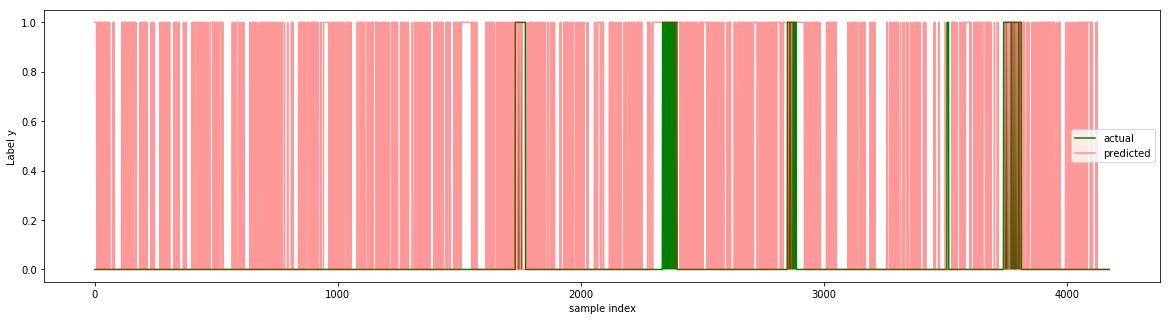

In [36]:
plot(test_labels, predicted_labels)